# Import nltk tools

In [13295]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Switch area
SUBJECT = 'description'
# SUBJECT_set_1 for col classify= [ 'brand', 'style', 'item', 'description', 'spec', 'width:', 'weight:', 'position', 'color_way', 'supplier', 'ref', 'qty', 'price/unit', 'unit', ]

VOCAB_SIZE = 900
# If VOCAB_SIZE is great than the row of database, it will cause error and stop the calculating on the step "Create Vocabulary with WORD_ID".

TEST_SIZE = 0.1 # proportion, the size of test_set

# for record the result in the excel file.
RECORD_FILE = 'Matrix_and_Trained-data_records_main-file.csv'

# Remenber to fillout it by manual !!!!!
# The matrix you used in the 010_01_Matrix_Generator, for checking the precision of matrix, 
MATRIX = 'col_classify_matrix_trimed_delete-none-material-col_20200404.csv'
# MATRIX = 'col_classify_matrix_trimed_20200330_double_the_True_description.csv'

# Wrod processing

In [13296]:
data = pd.read_csv('result/Matrix/' + SUBJECT + '_matrix.csv')

* Name the index as "MATERIAL_IDs"
* The matrix must has it unrepeated Id before import to here, show as the "Unnamed: 0".

In [13297]:
data.head()

,Unnamed: 0,material,description
0,0,", scott usa",0
1,1,", scott usa",0
2,2,", scott usa",0
3,3,", scott usa",0
4,4,", scott usa",0


* Change the col "Unnamed: 0" as "MATERIAL_ID"

In [13298]:
data.rename( columns = {'Unnamed: 0': 'MATERIAL_ID'}, inplace = True)

In [13299]:
data.head()

,MATERIAL_ID,material,description
0,0,", scott usa",0
1,1,", scott usa",0
2,2,", scott usa",0
3,3,", scott usa",0
4,4,", scott usa",0


* Set the original index as Index

In [13300]:
data.set_index('MATERIAL_ID', inplace = True)

In [13301]:
data.tail()

,material,description
MATERIAL_ID,,
6468,", pop in puller- #5 ', 'pop in puller- #...",1
6469,", pop in puller- #5 ', 'direct MATTE print'",1
6470,", coated taffetta'",1
6471,", 3.5mm, 2-color, Cording; with Metal Cord Ends'",1
6472,", Spring Toggles/1Hole', 'Spring Toggles/2Hole...",1


## Nltk Function

In [13302]:
def nltk_convert(col_of_df):
    '''
    Parameter of this function is a column of a dataFrame.
    
    '''
    # difine Stop words
    stop_words = set(stopwords.words('english'))
    # Difine Stemmer
    stemmer = SnowballStemmer('english')
    
    # converts to lower case and splits up the words
    words = word_tokenize(col_of_df)
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        # if word is not in the stop_words list and is not a alpha.
        if word not in stop_words and word.isalpha():
#             filtered_words.append(stemmer.stem(word))
            filtered_words.append(word)
            
    return filtered_words

* Test the function, with row 0, in column 'material'

In [13303]:
nltk_convert(data.at[0, 'material'])

['scott', 'usa']

## Applying to the matrix
* the variable "nested_list" will hold the result.
* It is a series in this moment.

In [13304]:
%%time
nested_list = data.material.apply(nltk_convert)

CPU times: user 4.96 s, sys: 254 ms, total: 5.21 s
Wall time: 5.43 s


In [13305]:
type(nested_list)

pandas.core.series.Series

## True and False categories
* Exact the index of fabric materials, and non fabric materials

In [13306]:
material_ids_ctg_1 = data[data[SUBJECT] == 1].index
material_ids_ctg_0 = data[data[SUBJECT] ==0].index

In [13307]:
material_ids_ctg_1

Int64Index([1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245,
            ...
            6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472],
           dtype='int64', name='MATERIAL_ID', length=2904)

### Get materials back by index
* Exact the strings in col 'material' by the index of doc_ids_fabric

In [13308]:
nested_list_ctg_1 = nested_list.loc[material_ids_ctg_1]

In [13309]:
nested_list_ctg_1

MATERIAL_ID
1236    [overlay, lower, right, pocket, coil, closed, ...
1237    [fabric, collar, cuffs, hem, vislon, open, end...
1238    [x, nylon, spandex, plain, weave, cire, finish...
1239    [x, nylon, plain, weave, cire, finish, dwr, fi...
1240    [using, main, fabric, per, mens, puffer, vest,...
                              ...                        
6468    [pop, flatlock, stitch, flatlock, stitch, MATT...
6469                                  [pop, MATTE, print]
6470                                   [coated, taffetta]
6471                         [Cording, Metal, Cord, Ends]
6472                                             [Spring]
Name: material, Length: 2904, dtype: object

* by the index of doc_ids_trim

In [13310]:
nested_list_ctg_0 = nested_list.loc[material_ids_ctg_0]

In [13311]:
nested_list_ctg_0.shape[0]

3569

## Number of Distinct words
* The Ctg_1

In [13312]:
flat_list_ctg_1 =[item for sublist in nested_list_ctg_1 for item in sublist]

In [13313]:
ctg_1_words = pd.Series(flat_list_ctg_1).value_counts()

In [13314]:
ctg_1_words.shape

(811,)

* The Ctg_0

In [13315]:
flat_list_ctg_0 = [item for sublist in nested_list_ctg_0 for item in sublist]

In [13316]:
ctg_0_words = pd.Series(flat_list_ctg_0).value_counts()

In [13317]:
ctg_0_words.head()

black     2214
pocket    1738
color     1728
side      1483
shell     1444
dtype: int64

# Generate Vocabulary
## Top 10 words in Matrix (ctg_1 and ctg_0)

* It is same as function the nltk_convert, the difference is in the end of the funciton, it not append word directly, but word converted by function stemmer.stem.

In [13318]:
def stemmered_nltk_convert(col_of_df):
    '''
    Parameter of this function is a column of a dataFrame.
    
    '''
    # difine Stop words
    stop_words = set(stopwords.words('english'))
    # Difine Stemmer
    stemmer = SnowballStemmer('english')
    
    # converts to lower case and splits up the words
    words = word_tokenize(col_of_df)
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        # if word is not in the stop_words list and is not a alpha.
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [13319]:
%%time
stemmed_nested_list = data.material.apply(stemmered_nltk_convert)

CPU times: user 8.92 s, sys: 263 ms, total: 9.18 s
Wall time: 9.34 s


* Get flat list for all words

In [13320]:
flat_stemmed_nested_list = [item for sublist in stemmed_nested_list for item in sublist]

* Turn it to a series

In [13321]:
unique_words = pd.Series(flat_stemmed_nested_list).value_counts()

In [13322]:
unique_words

zipper    8166
label     7819
slider    5900
coil      5505
suppli    4374
          ... 
luula        1
kit          1
zag          1
jokka        1
bronz        1
Length: 1458, dtype: int64

* Set the size of vacabulary
* This size need to be tested a lot, in this cace, follow the e-mail processing lecture, I takes 10 % of total particular words

In [13323]:
VOCAB_SIZE

900

In [13324]:
frequent_words = unique_words[0:VOCAB_SIZE]

In [13325]:
print('Most common words: \n', frequent_words[:10])

Most common words: 
 zipper    8166
label     7819
slider    5900
coil      5505
suppli    4374
tape      3527
metal     3068
nylon     2970
side      2889
black     2711
dtype: int64


## Create Vocabulary with WORD_ID

In [13326]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,zipper
1,label
2,slider
3,coil
4,suppli


* Save the vocabulary

In [13327]:
vocab.to_csv('result/Trained Data/Vocabulary/'+SUBJECT+'_vocabulary.csv')

* Test the any word to see if it is in the vocabulary

In [13328]:
'hangtag' in set(vocab.VOCAB_WORD)

True

## Search out the material with most token

In [13329]:
clean_material_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr wrods in the longest material:', max(clean_material_lengths))

Nr wrods in the longest material: 2510


In [13330]:
print('Material position in the list', np.argmax(clean_material_lengths))

Material position in the list 870


In [13331]:
stemmed_nested_list[np.argmax(clean_material_lengths)]

['nitro',
 'men',
 'jacket',
 'sampl',
 'size',
 'larg',
 'winter',
 'contractor',
 'soluna',
 'number',
 'date',
 'creat',
 'name',
 'summit',
 'packabl',
 'date',
 'revis',
 'block',
 'base',
 'powel',
 'fit',
 'mtn',
 'fit',
 'seal',
 'fulli',
 'seam',
 'tape',
 'fit',
 'regular',
 'no',
 'insul',
 'target',
 'fob',
 'colorway',
 'fabric',
 'refer',
 'number',
 'locat',
 'content',
 'refer',
 'number',
 'locat',
 'content',
 'tape',
 'refer',
 'number',
 'locat',
 'content',
 'refer',
 'number',
 'locat',
 'content',
 'men',
 'jacket',
 'sampl',
 'size',
 'larg',
 'winter',
 'contractor',
 'soluna',
 'number',
 'date',
 'creat',
 'name',
 'summit',
 'packabl',
 'date',
 'revis',
 'block',
 'base',
 'powel',
 'fit',
 'mtn',
 'fit',
 'seal',
 'fulli',
 'seam',
 'tape',
 'fit',
 'regular',
 'no',
 'insul',
 'target',
 'fob',
 'refer',
 'number',
 'locat',
 'amount',
 'zipper',
 'pull',
 'refer',
 'number',
 'locat',
 'amount',
 'trim',
 'refer',
 'number',
 'locat',
 'amount',
 'refer'

# Generate Features & Spare Matrix
### Creating a DataFrame with one word per column

In [13332]:
type(stemmed_nested_list)

pandas.core.series.Series

In [13333]:
stemmed_nested_list

MATERIAL_ID
0                                            [scott, usa]
1                                            [scott, usa]
2                                            [scott, usa]
3                                            [scott, usa]
4                                            [scott, usa]
                              ...                        
6468    [pop, flatlock, stitch, flatlock, stitch, matt...
6469                                   [pop, matt, print]
6470                                     [coat, taffetta]
6471                             [cord, metal, cord, end]
6472                                             [spring]
Name: material, Length: 6473, dtype: object

In [13334]:
type(stemmed_nested_list.tolist())

list

In [13335]:
word_col_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_col_df

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
0,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,pop,flatlock,stitch,flatlock,stitch,matt,print,matt,print,grosgrain,...,None,None,None,None,None,None,None,None,None,None
6469,pop,matt,print,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6470,coat,taffetta,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6471,cord,metal,cord,end,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Traning Set and Test Set
* Must import the method "train_test_split()" from sklearn

In [13336]:
X_train, X_test, y_train, y_test = train_test_split(word_col_df, data[SUBJECT],
                                                    test_size = TEST_SIZE)

In [13337]:
print('Nr of traning samples', X_train.shape[0])
print('Fraction of traning set', X_train.shape[0] / word_col_df.shape[0])

Nr of traning samples 5825
Fraction of traning set 0.8998918584891086


In [13338]:
X_train.index.name = X_test.index.name = 'MATERIAL_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
2771,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
22,blair,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
183,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
437,w,defin,mid,pullov,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2336,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [13339]:
y_train.head()

MATERIAL_ID
2771    0
22      0
183     0
437     0
2336    0
Name: description, dtype: int64

## Sparse Matrix for the traning data
* Get vocabulary turned as an Index:

In [13340]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['zipper', 'label', 'slider', 'coil', 'suppli', 'tape', 'metal', 'nylon',
       'side', 'black',
       ...
       'ast', 'construct', 'of', 'powermet', 'plus', 'caf', 'huamao', 'delko',
       'teddi', 'ottoman'],
      dtype='object', name='VOCAB_WORD', length=900)

In [13341]:
y_train.shape[0]

5825

### Sparse Matrix Function

In [13342]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a sparse matrix as dataframe
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'MATERIAL_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

## Training data
### Applying to the traning set

In [13343]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 1min 24s, sys: 588 ms, total: 1min 25s
Wall time: 1min 35s


In [13344]:
sparse_train_df

,LABEL,MATERIAL_ID,OCCURENCE,WORD_ID
0,0,437,1,74
1,0,437,1,625
2,0,437,1,481
3,0,437,1,630
4,1,4458,1,404
...,...,...,...,...
234222,1,5162,1,586
234223,1,5162,1,53
234224,1,5162,1,10
234225,1,5162,1,50


In [13345]:
sparse_train_df.shape

(234227, 4)

### Group by the DOC_ID

In [13346]:
train_grouped = sparse_train_df.groupby(['MATERIAL_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped

OCCURENCE
MATERIAL_ID WORD_ID LABEL           
0           712     0              1
            719     0              1
1           712     0              1
            719     0              1
2           712     0              1
...                              ...
6469        151     1              1
            519     1              1
6470        96      1              1
            671     1              1
6472        878     1              1

[80521 rows x 1 columns]

* Distribute the DOC_ID to each row

In [13347]:
train_grouped = train_grouped.reset_index()

In [13348]:
train_grouped

,MATERIAL_ID,WORD_ID,LABEL,OCCURENCE
0,0,712,0,1
1,0,719,0,1
2,1,712,0,1
3,1,719,0,1
4,2,712,0,1
...,...,...,...,...
80516,6469,151,1,1
80517,6469,519,1,1
80518,6470,96,1,1
80519,6470,671,1,1


### Save Traning Data
* We save it as a txt file, with only numbers of the IDs, Occurances, label, as showed above. 

In [13349]:
np.savetxt('result/Trained Data/' + SUBJECT + '_sparse_traning_data', train_grouped, fmt = '%d')

## Test Data
* The way to create it is basically same way as treating traning data.

In [13350]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
1843,fli,pocket,brand,trim,fli,left,hand,pocket,pocket,edg,...,None,None,None,None,None,None,None,None,None,None
5242,polyfil,coat,tricot,tricot,stretch,mesh,vislon,zipper,aquaguard,coil,...,None,None,None,None,None,None,None,None,None,None
203,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3949,ykk,revers,coil,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5606,spi,spi,size,label,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [13351]:
y_test.head()

MATERIAL_ID
1843    0
5242    1
203     0
3949    1
5606    1
Name: description, dtype: int64

In [13352]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 8.44 s, sys: 62.9 ms, total: 8.5 s
Wall time: 8.76 s


In [13353]:
test_grouped = sparse_test_df.groupby(['MATERIAL_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,MATERIAL_ID,WORD_ID,LABEL,OCCURENCE
0,4,712,0,1
1,4,719,0,1
2,48,47,0,1
3,55,47,0,1
4,64,294,0,1


In [13354]:
np.savetxt('result/Trained Data/' + SUBJECT + '_sparse_test_data', test_grouped, fmt = '%d')

# Full Matrix
* Create anempty df first

### Columns of Full Matrix
* The empty df with column 'DOC_ID', in the case I use 'MATERIAL_ID'
* Second column is 'CATEGORY'
* The rest column is number from 0 to the number of words in vocabulary.

In [13355]:
column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))

### Rows of Full Matrix
* If consists of Material_ID in Training Data
* Numpy method np.unique() will take a number 1 time, even it occurs many time in the Traning Data.
* Import the traning data we saved as txt

In [13356]:
TRANING_DATA = 'result/Trained Data/' + SUBJECT + '_sparse_traning_data'

* Open it by Numpy

In [13357]:
sparse_train_data = np.loadtxt(TRANING_DATA, delimiter = ' ', dtype=int)

In [13358]:
index_names = np.unique(sparse_train_data[:, 0])

### Form the Data Frame
* Create an empty df, columned by column_names, indexed by index_names
* Fullfill all the cell with value "0"

In [13359]:
full_train_data = pd.DataFrame(index= index_names, columns = column_names)
full_train_data.fillna(value = 0, inplace = True)
full_train_data.shape

(4778, 902)

## Make a Full matrix function

In [13360]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx = 0, word_idx = 1, cat_idx = 2, freq_idx = 3):
    column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:,0])
    full_matrix = pd.DataFrame(index = doc_id_names, columns = column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurrence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, 'MATERIAL_ID'] = doc_nr
        full_matrix.at[doc_nr, 'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurrence
        
    full_matrix.set_index('MATERIAL_ID', inplace = True)
    return full_matrix

In [13361]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

CPU times: user 3.54 s, sys: 166 ms, total: 3.71 s
Wall time: 4.88 s


In [13362]:
full_train_data

,CATEGORY,0,1,2,3,4,5,6,7,8,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6467,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6468,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6469,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Probability of Category_1 in train_data

In [13363]:
full_train_data.CATEGORY.size

4778

In [13364]:
full_train_data.CATEGORY.sum()

2615

In [13365]:
prob_ctg_1 = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print('Probability  of ' + SUBJECT +' is', prob_ctg_1)

Probability  of description is 0.5473001255755546


In [13366]:
prob_ctg_1

0.5473001255755546

In [13367]:
prob_ctg_1_in_train_data = pd.DataFrame({'prob_ctg_1_train_set':[prob_ctg_1]})

In [13368]:
prob_ctg_1_in_train_data.to_csv('result/Trained Data/Train_set/' + SUBJECT + '_prob_ctg_1_in_train_data')

# Count each material in train_data have how many tokens
## Full train Features
* It is very simple. The whole df of train_data without the column 'CATEGORY' is the Full train Features
* Create a new df with no column 'CATEGORY'

In [13369]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']

In [13370]:
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13371]:
# full_train_features[1249].sum()

### Number of tokens each material has in train_data
* We added up all values in row direction, to get sum of each row 

In [13372]:
material_train_data = full_train_features.sum(axis = 1) 
material_train_data.shape # Show how many materials in train_data

(4778,)

In [13373]:
material_train_data # Show how many words each material in train_data has

MATERIAL_ID
0        2
1        2
2        2
3        2
5        2
        ..
6467     1
6468    11
6469     3
6470     2
6472     1
Length: 4778, dtype: int64

* Total number of words in train_data

In [13374]:
total_words_train_data = material_train_data.sum()
total_words_train_data

234227

#### Token of ctg_1 in train_data
* Number of particular words of category 1, in train_data
* The word can be called "token"

In [13375]:
ctg_1_in_train_data = material_train_data[full_train_data.CATEGORY == 1]
ctg_1_in_train_data.shape
# 1379 materials in train_data is fabric

(2615,)

In [13376]:
ctg_1_token_in_train_data = ctg_1_in_train_data.sum()
ctg_1_token_in_train_data
# The total words in Category 1, the fabric, in the train_data

171188

#### Token of trim in train_data
* Number of particular words of category 0, the trim, in train_data

In [13377]:
ctg_0_in_train_data = material_train_data[full_train_data.CATEGORY == 0]
ctg_0_in_train_data.shape 
# Total, 5026 materials in train_data is trim

(2163,)

In [13378]:
ctg_0_token_in_train_data = ctg_0_in_train_data.sum()
ctg_0_token_in_train_data 
# Total words in Category 0, the trim, in the train_data

63039

### Average number of words in fabric and trim
* In this case, CATEGORY 1 is fabric, 0 is trim

In [13379]:
print('Average nr of words in ctg_1 {:.0f}'.format(ctg_1_token_in_train_data / ctg_1_in_train_data.shape[0]))
print('Average nr of words in ctg_0 {:.0f}'.format(ctg_0_token_in_train_data / ctg_0_in_train_data.shape[0]))

Average nr of words in ctg_1 65
Average nr of words in ctg_0 29


In [13380]:
# The snippet is for testing if the calculating get problem.
# The answer should eaquls to 0
material_train_data.shape[0] - ctg_1_in_train_data.shape[0] - ctg_0_in_train_data.shape[0]

0

# Count each token's frequency in both Category
## Full train Features of ctg_1
* It is very simple. The df of train_data in 'CATEGORY'1, and without the column 'CATEGORY' is the Full train Features of Fabric

In [13381]:
ctg_1_full_train_features = full_train_features.loc[full_train_data.CATEGORY == 1]

In [13382]:
ctg_1_full_train_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
1236,0,2,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1237,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1238,8,6,8,6,0,0,5,4,2,0,...,0,0,0,0,0,0,0,0,0,0
1239,8,6,8,4,0,0,4,4,2,0,...,0,0,0,0,0,0,0,0,0,0
1241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Full train feature of trim

In [13383]:
ctg_0_full_train_features = full_train_features.loc[full_train_data.CATEGORY == 0]

In [13384]:
ctg_0_full_train_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Frequency of tokens in fabric in train_data
* We add up all value in column direction to get sum of each column.
* The sum represents each word occurs how many time in the category 1, the fabric.
* It is possible that some words in vocabulary never appear in this category, so we need "+ 1" to this token. Since later we'll divide it to get the percentage, if you divide 0, it may cause error.

In [13385]:
summed_ctg_1_tokens_in_train_data = ctg_1_full_train_features.sum(axis = 0) + 1

In [13386]:
summed_ctg_1_tokens_in_train_data

0      6195
1      5877
2      4858
3      4742
4      3823
       ... 
895       1
896      12
897      12
898      12
899       1
Length: 900, dtype: int64

### Frequency of tokens in trim in train_data
* The way treat it as treating with fabric

In [13387]:
summed_ctg_0_tokens_in_train_data = ctg_0_full_train_features.sum(axis = 0) + 1

In [13388]:
summed_ctg_0_tokens_in_train_data

0      1120
1      1120
2       456
3       209
4       129
       ... 
895       9
896       1
897       1
898       1
899      12
Length: 900, dtype: int64

# Probability of tokens
* Why here not only divided the frequency of each token by total tokens but also the size of vocabulary? It is becasue we add "+ 1" for each word when counting frequency, so add the size of vocabulary is for balancing the number back.

## P of Training Set 
### Probability of tokens in fabric in train_data
* ### P( Token | ctg_1 )
* Take the each summed up occurance divided by the total nubmer of token in category of fabric.

In [13389]:
prob_tokens_ctg_1_train_set = summed_ctg_1_tokens_in_train_data / (ctg_1_token_in_train_data + VOCAB_SIZE)

In [13390]:
ctg_1_token_in_train_data

171188

In [13391]:
prob_tokens_ctg_1_train_set

0      0.035999
1      0.034151
2      0.028230
3      0.027556
4      0.022215
         ...   
895    0.000006
896    0.000070
897    0.000070
898    0.000070
899    0.000006
Length: 900, dtype: float64

### Probability of tokens in trim in train_data
* ### P( Token | ctg_0 )

In [13392]:
prob_tokens_ctg_0_train_set = summed_ctg_0_tokens_in_train_data / (ctg_0_token_in_train_data + VOCAB_SIZE)

In [13393]:
prob_tokens_ctg_0_train_set

0      0.017517
1      0.017517
2      0.007132
3      0.003269
4      0.002018
         ...   
895    0.000141
896    0.000016
897    0.000016
898    0.000016
899    0.000188
Length: 900, dtype: float64

* Check if the number correct.
* The answer should be "1"

In [13394]:
prob_tokens_ctg_0_train_set.sum()

1.0

* Test for the prob

In [13395]:
check = prob_tokens_ctg_1_train_set[20] > prob_tokens_ctg_0_train_set[20]
check

False

### Probability of tokens in train_data
* ### P (Token)

In [13396]:
prob_tokens_all_train_set = full_train_features.sum(axis = 0) / total_words_train_data

In [13397]:
prob_tokens_all_train_set

0      0.031222
1      0.029864
2      0.022679
3      0.021129
4      0.016864
         ...   
895    0.000034
896    0.000047
897    0.000047
898    0.000047
899    0.000047
Length: 900, dtype: float64

In [13398]:
prob_tokens_all_train_set.sum()

0.9999999999999999

### Save the trained Model
* P( Token | ctg_1 )
* P( Token | ctg_0 )
* P ( Token )

In [13399]:
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_ctg_1_in_train_data' ,prob_tokens_ctg_1_train_set)
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_ctg_0_in_train_data', prob_tokens_ctg_0_train_set)
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_all_in_train_data', prob_tokens_all_train_set)

## P of Test Set
### Probability of tokens in trim in train_data
* ### P( Token | ctg_0 )

* Start from Sparse Matrix of test_set
* Trun the Sparse Matrix to Full Matrix
* Get the number of word of material by summing each row of Full Matrix
* Get the frequency of each word by summing each column of Full Matrix
* Get all this result from test set : P ( Token | ctg_1 ), P (Token | ctg_0 ), P ( Token ) 
 

### Full matrix of test data
#### Import test data Sparse Matrix

In [13400]:
TEST_DATA = 'result/Trained Data/' + SUBJECT + '_sparse_test_data'
sparse_test_data = np.loadtxt(TEST_DATA, delimiter = ' ', dtype = int )

#### Create a empty Full Matrix
* Column and row of Full Matrix

In [13401]:
column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
index_names = np.unique(sparse_test_data[:, 0]) # 1 material_id only for 1 row, without duplicated

#### The custom function make_full_matrix
* empty dataFrame for Full matrix 
* Filled the values from sparse matrix by column match to WORD_ID, the row match to MATERIAL_ID

In [13402]:
%%time
full_test_data = make_full_matrix(sparse_test_data, VOCAB_SIZE) 

CPU times: user 538 ms, sys: 13.9 ms, total: 552 ms
Wall time: 580 ms


In [13403]:
full_test_data

,CATEGORY,0,1,2,3,4,5,6,7,8,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6420,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Probability in test data
#### Ctg_1

In [13404]:
full_test_data.CATEGORY.size

515

In [13405]:
full_test_data.CATEGORY.sum()

267

In [13406]:
prob_ctg_1_test_data = full_test_data.CATEGORY.sum() / full_test_data.CATEGORY.size
print('Probability of ctg_1 in test_set', prob_ctg_1_test_data)

Probability of ctg_1 in test_set 0.5184466019417475


### Full Features of test_set

In [13407]:
full_test_features = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']

In [13408]:
full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6420,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6431,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Number of tokens each material has in test_data

In [13409]:
material_test_data = full_test_features.sum(axis = 1)
material_test_data[:5]

MATERIAL_ID
4     2
48    1
55    1
64    1
70    1
dtype: int64

* Total number of words in test_data

In [13410]:
total_words_test_data = material_test_data.sum()
total_words_test_data

29995

#### Token of ctg_1 in test_data

In [13411]:
ctg_1_in_test_data = material_test_data[full_test_data.CATEGORY == 1]
ctg_1_in_test_data.shape

(267,)

In [13412]:
ctg_1_token_in_test_data = ctg_1_in_test_data.sum()
ctg_1_token_in_test_data

19904

#### Token of ctg_0 in test_data

In [13413]:
ctg_0_in_test_data = material_test_data[full_test_data.CATEGORY == 0]
ctg_0_in_test_data.shape

(248,)

In [13414]:
ctg_0_token_in_test_data = ctg_0_in_test_data.sum()
ctg_0_token_in_test_data

10091

#### Average number of words in fabric and trim in test_data

In [13415]:
print('Average nr of words in ctg_1 {:.0f}'.format(ctg_1_token_in_test_data / ctg_1_in_test_data.shape[0]))
print('Average nr of words in ctg_0 {:.0f}'.format(ctg_0_token_in_test_data / ctg_0_in_test_data.shape[0]))

Average nr of words in ctg_1 75
Average nr of words in ctg_0 41


### Frequency of tokens in test_data
* Full feature of ctg_1 in test_data

In [13416]:
ctg_1_full_test_features = full_test_features.loc[full_test_data.CATEGORY == 1]
ctg_1_full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
1240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1246,2,4,0,4,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1258,0,14,0,0,0,0,8,6,0,4,...,0,0,0,0,0,0,0,0,0,0
1263,0,6,0,0,0,0,6,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1304,8,4,6,6,12,0,4,6,6,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6420,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6431,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Full feature of ctg_0 in test_data

In [13417]:
ctg_0_full_test_features = full_test_features.loc[full_test_data.CATEGORY == 0]
ctg_0_full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Frequency of tokens in ctg_1 in test_data

In [13418]:
summed_ctg_1_tokens_in_test_data = ctg_1_full_test_features.sum(axis = 0) +1 
summed_ctg_1_tokens_in_test_data

0      704
1      692
2      501
3      529
4      425
      ... 
895      1
896      1
897      1
898      1
899      1
Length: 900, dtype: int64

#### Frequency of tokens in ctg_0 in test_data

In [13419]:
summed_ctg_0_tokens_in_test_data = ctg_0_full_test_features.sum(axis = 0) +1 
summed_ctg_0_tokens_in_test_data

0      151
1      134
2       89
3       29
4        1
      ... 
895      4
896      1
897      1
898      1
899      1
Length: 900, dtype: int64

## P of Test Set
* ### P( Token | ctg_1 )

In [13420]:
prob_tokens_ctg_1_test_set = summed_ctg_1_tokens_in_test_data / (ctg_1_token_in_test_data + VOCAB_SIZE)

In [13421]:
prob_tokens_ctg_1_test_set

0      0.033840
1      0.033263
2      0.024082
3      0.025428
4      0.020429
         ...   
895    0.000048
896    0.000048
897    0.000048
898    0.000048
899    0.000048
Length: 900, dtype: float64

* ### P( Token | ctg_0 )

In [13422]:
prob_tokens_ctg_0_test_set = summed_ctg_0_tokens_in_test_data / (ctg_0_token_in_test_data + VOCAB_SIZE)

In [13423]:
prob_tokens_ctg_0_test_set

0      0.013739
1      0.012192
2      0.008098
3      0.002639
4      0.000091
         ...   
895    0.000364
896    0.000091
897    0.000091
898    0.000091
899    0.000091
Length: 900, dtype: float64

* ### P( Token )

In [13424]:
prob_tokens_all_test_set = full_test_features.sum(axis = 0) / total_words_test_data

In [13425]:
prob_tokens_all_test_set

0      0.028438
1      0.027471
2      0.019603
3      0.018536
4      0.014136
         ...   
895    0.000100
896    0.000000
897    0.000000
898    0.000000
899    0.000000
Length: 900, dtype: float64

In [13426]:
prob_tokens_all_test_set.sum()

1.0

### Save the test Model
* P( Token | ctg_1 )
* P( Token | ctg_0 )
* P ( Token )

In [13427]:
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_ctg_1_in_test_data' ,prob_tokens_ctg_1_test_set)
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_ctg_0_in_test_data', prob_tokens_ctg_0_test_set)
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_all_in_test_data', prob_tokens_all_test_set)

# Joint probability
* Get the the full feature of test_set
* Get full target of test_set
* Take each cell in Full features of test_set times the probability of fabric in train_set

### Full feature of test_set

In [13428]:
full_test_features = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']
full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6420,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6431,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Full target of test_set

In [13429]:
full_test_target = full_test_data.CATEGORY
full_test_target

MATERIAL_ID
4       0
48      0
55      0
64      0
70      0
       ..
6411    1
6420    1
6431    1
6465    1
6471    1
Name: CATEGORY, Length: 515, dtype: int64

### Probability of ctg_1 of Test_set
* The frequancy of tokens in test_set x The probability of tokens in train_set

In [13430]:
prob_tokens_ctg_1_train_set

0      0.035999
1      0.034151
2      0.028230
3      0.027556
4      0.022215
         ...   
895    0.000006
896    0.000070
897    0.000070
898    0.000070
899    0.000006
Length: 900, dtype: float64

In [13431]:
joint_pty = full_test_features.dot(prob_tokens_ctg_1_train_set)
joint_pty

MATERIAL_ID
4       0.000012
48      0.006468
55      0.006468
64      0.000552
70      0.000552
          ...   
6411    0.067617
6420    0.039788
6431    0.079901
6465    0.010564
6471    0.048254
Length: 515, dtype: float64

# Prior
* Prior is the percentage of event that we get from the datas.
* If we want to count the fabric, Prior in this case is the probability of fabric.
* numbers of fabric / total material.

P( ctg_1 | documents )  = 
P( documentsl | ctg_1 ) * P( ctg_1) / P( document )


# Joint probability in log format
* Ctg_1 joint prob in log format

In [13432]:
joint_log_ctg_1 = full_test_features.dot(np.log(prob_tokens_ctg_1_train_set) - np.log(prob_tokens_all_train_set)) + np.log(prob_ctg_1) 

In [13433]:
joint_log_ctg_1[:5]

MATERIAL_ID
4    NaN
48   NaN
55   NaN
64   NaN
70   NaN
dtype: float64

* Ctg_0 joint prob in log format

In [13434]:
joint_log_ctg_0 = full_test_features.dot(np.log(prob_tokens_ctg_0_train_set) - np.log(prob_tokens_all_train_set)) + np.log(1 - prob_ctg_1) 

In [13435]:
joint_log_ctg_0[:5]

MATERIAL_ID
4    NaN
48   NaN
55   NaN
64   NaN
70   NaN
dtype: float64

## Simplify Joint probability in log format
* Only in the comparison situation can take away the snippet, in other condition, it will lead to a wrong result.

In [13436]:
joint_log_ctg_1 = full_test_features.dot(np.log(prob_tokens_ctg_1_train_set)) + np.log(prob_ctg_1)
joint_log_ctg_0 = full_test_features.dot(np.log(prob_tokens_ctg_0_train_set)) + np.log(1-prob_ctg_1)

# Prediction

In [13437]:
prediction = joint_log_ctg_1 > joint_log_ctg_0

* Check if the prediction got wrong.
* If the joint_log_fabric bigger than joint_log_trim, show true. times 1 is for the boolean tured into numbrer 0 or 1.
* If the material shows 1 means it is have more possibility as a fabric.
* Then we compare the category list of the test_set to see if the prediction is same as the category of test_set

In [13438]:
joint_log_ctg_1.min()

-13711.508839924405

In [13439]:
prediction[-5:]*1

MATERIAL_ID
6411    1
6420    1
6431    1
6465    1
6471    1
dtype: int64

In [13440]:
full_test_target[-5:]

MATERIAL_ID
6411    1
6420    1
6431    1
6465    1
6471    1
Name: CATEGORY, dtype: int64

### Check the accuracy of this model

In [13441]:
correct_materials = (full_test_target == prediction).sum()
print('Does classified correctly', correct_materials)
num_materials_wrong = full_test_features.shape[0] - correct_materials
print('Does classfied incorrectly', num_materials_wrong)

Does classified correctly 434
Does classfied incorrectly 81


### Accuracy %

In [13442]:
correct_materials / len(full_test_features)

0.8427184466019417

# Decision Boundary
## Visualizing the results

In [13443]:
yaxis_label = 'P(X | ' + SUBJECT + ')'
xaxis_label = 'P(X | Others)'

linedata = np.linspace(start = -14000, stop = 1, num = 1000)

#Chart Styling
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({xaxis_label: joint_log_ctg_1, 
                           yaxis_label: joint_log_ctg_0, 
                           labels: full_test_target})

## The Decision Boundary
* Since we transfored both joint probability, fabric and trim, into log format, so the value will be minus.

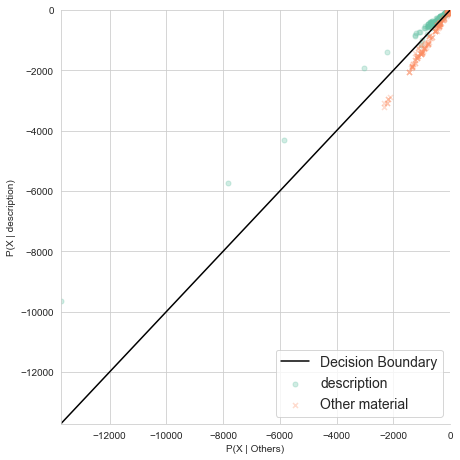

In [13444]:
sns.lmplot(x = xaxis_label, y = yaxis_label, 
           data =summary_df, height = 6.5, 
           fit_reg=False, legend=False, scatter_kws={'alpha': 0.3, 's': 25}, 
           hue = labels, markers = ['o', 'x'], palette = 'Set2' )

plt.xlim([joint_log_ctg_1.min() - 10, 1])
plt.ylim([joint_log_ctg_1.min() - 10, 1])

plt.plot(linedata, linedata, color = 'black')

plt.legend(('Decision Boundary', SUBJECT , 'Other material'), 
           loc='lower right', fontsize = 14)

plt.show()

# False Positives and False Negatives
* The function up.unique() shows the nubmer of value 0 is 2347, the value 1 is 650.

In [13445]:
np.unique(prediction, return_counts = True)

(array([False,  True]), array([239, 276]))

### True positives
* It shows, the document is 1, the True, and model also predicts it as 1, True.
* In this case, the material is fabric in CATEGORY, and the prediction also say it is fabric.

In [13446]:
true_pos = (y_test == 1)&(prediction == 1)

In [13447]:
true_pos.sum()

231

### True negatives
* It shows, the document is 0, the False, and the model also predicts it as 0, False.
* In this case, the material is actually trim in CATEGORY, and the prediction also say it is trim.

In [13448]:
true_neg = (y_test == 0)&(prediction ==0)

In [13449]:
true_neg.sum()

203

### False positives
* It shows, the document is 0, the False, and model predicts it as 1, True.
* In this case, the material is trim in CATEGORY, and yet prediction says it is fabric.

In [13450]:
false_pos = (y_test == 0)&(prediction ==1)

In [13451]:
false_pos.sum()

45

### False negtives
* It shows, the document is 1, the True, and model predicts it as 0, False.
* In this case, the material is fabric in CATEGORY, and yet prediction says it is trim.

In [13452]:
false_neg = (y_test == 1)&(prediction == 0)

In [13453]:
false_neg.sum()

36

In [13454]:
(y_test == 1).sum()

273

# Recall Score
* It tells how much the model will omit the document. More the value close to 1, less the model will omit to fit document.
* It tells the reliability of the model, in other words, how much the model resemble to the relevant documents.
* More the value close to 1, less the model will omit any document.

In [13455]:
recall_score = true_pos.sum() / (y_test == 1).sum()
print('Recall score is {:.2%}'. format(recall_score))

Recall score is 84.62%


# Precision Score
* It tells how precisely the model predicting.

In [13456]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print('Precision score is {:.3}'.format(precision_score))

Precision score is 0.837


# F-Score or F1 Score
* Closer the value to 1, better the model is.

In [13457]:
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print('F Score is {:.2}'.format(f1_score))

F Score is 0.84


# Record the result in a CSV file
* Record the result, so I can check the precision of the matrix

In [13458]:
record_file = pd.read_csv(RECORD_FILE, encoding = 'ISO-8859-1', index_col = 'RECORD_ID')

In [13459]:
record_file.tail()

,Csv,Rows,SUBJECT,VOCAB_SIZE,Test_size,True_Positives,True_Negatives,False_Positives,False_Negatives,TRUE_in y_test,Recall_Score,Precision_Score,F1-Score
RECORD_ID,,,,,,,,,,,,,
117,col_classify_matrix_trimed_delete-none-materia...,3820,spec,900,0.1,18,253,6,1,22,81.82%,0.750,0.78
118,col_classify_matrix_trimed_delete-none-materia...,3820,position,900,0.1,36,219,2,3,39,92.31%,0.947,0.94
119,col_classify_matrix_trimed_delete-none-materia...,3820,color_way,900,0.1,81,197,5,0,107,75.70%,0.942,0.84
120,col_classify_matrix_trimed_delete-none-materia...,6473,description,900,0.1,249,206,49,38,288,86.46%,0.836,0.85
121,col_classify_matrix_trimed_delete-none-materia...,6473,description,900,0.1,262,198,40,30,296,88.51%,0.868,0.88


In [13460]:
# For record in cxcel file
new_record = {
    'Csv':MATRIX,
    'Rows':data.shape[0],
    'SUBJECT':SUBJECT,
    'VOCAB_SIZE':VOCAB_SIZE,
    'Test_size':TEST_SIZE,
    'True_Positives':true_pos.sum(),
    'True_Negatives':true_neg.sum(),
    'False_Positives':false_pos.sum(),
    'False_Negatives':false_neg.sum(),
    'TRUE_in y_test':(y_test == 1).sum(),
    'Recall_Score':'{:.2%}'. format(recall_score),
    'Precision_Score':'{:.3}'.format(precision_score),
    'F1-Score':'{:.2}'.format(f1_score),
}

In [13461]:
# the attribute 'name' of the df method .append in this case represents the index column 'RECORD_ID'
record_file = record_file.append(pd.Series(new_record, name = record_file.shape[0]), ignore_index = False)

In [13462]:
record_file.tail()

,Csv,Rows,SUBJECT,VOCAB_SIZE,Test_size,True_Positives,True_Negatives,False_Positives,False_Negatives,TRUE_in y_test,Recall_Score,Precision_Score,F1-Score
RECORD_ID,,,,,,,,,,,,,
118,col_classify_matrix_trimed_delete-none-materia...,3820,position,900,0.1,36,219,2,3,39,92.31%,0.947,0.94
119,col_classify_matrix_trimed_delete-none-materia...,3820,color_way,900,0.1,81,197,5,0,107,75.70%,0.942,0.84
120,col_classify_matrix_trimed_delete-none-materia...,6473,description,900,0.1,249,206,49,38,288,86.46%,0.836,0.85
121,col_classify_matrix_trimed_delete-none-materia...,6473,description,900,0.1,262,198,40,30,296,88.51%,0.868,0.88
122,col_classify_matrix_trimed_delete-none-materia...,6473,description,900,0.1,231,203,45,36,273,84.62%,0.837,0.84


In [13463]:
# Add time set for record file name.
import datetime
now = datetime.datetime.now()
today = now.strftime('%Y-%m-%d')
print(today)

2020-04-06


## Save the record file
* Here we save 2 copies, 1 for the main file, it will be covered and reused for next time.
* The other is a file with the date of today as backup saving in the directory 'record'

In [13464]:
# Save a copy to the directory 'record'
record_file.to_csv('record/Matrix_and_Trained-data_records_'+ today +'.csv')
# Save and cover the main file.
record_file.to_csv('Matrix_and_Trained-data_records_main-file.csv')